# Feature Neutralization

One thing that makes predicting the stock market so hard is the "non-stationary" relationship between features and returns. Features can have strong predictive power some eras but not others - or may completely reverse over time.

This uncertainty is what we call "feature risk". In order to create models that have consistent performance, it is helpful to reduce this feature risk via "feature neutralization". In this notebook, we will:

1. Learn how to quantify feature risk
2. Measure our model's feature exposure
3. Apply feature neutralization to our predictions
4. Measure the performance of our neutralized predictions
5. Pickle and upload our feature-neutral model

In [1]:
!python --version

Python 3.12.11


In [3]:
# Install dependencies
!pip install -q --upgrade numerapi pandas pyarrow matplotlib lightgbm scikit-learn scipy cloudpickle==3.1.1
!pip install -q --no-deps numerai-tools

# Inline plots
%matplotlib inline

## 1. Feature Risk

In order to quantify feature risk, we evaluate the performance of each feature on their own.

### Feature Groups
In the last notebook, you learned about the basic feature sets that Numerai offers. There are also 8 feature groups: `intelligence`, `wisdom`, `charisma`, `dexterity`, `strength`, `constitution`, `agility`, `serenity`. Each group contains a different type of feature. For example all technical signals would be in one group, while all analyst predictions and ratings would be in another group.

Let us take a look at feature groups in the small, medium, and all feature sets:

In [4]:
import json
import pandas as pd
from numerapi import NumerAPI

# initialize our API client
napi = NumerAPI()

# Set data version to one of the latest datasets
DATA_VERSION = "v5.0"

napi.download_dataset(f"{DATA_VERSION}/features.json")
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
feature_sets = feature_metadata["feature_sets"]

sizes = ["small", "medium", "all"]
groups = [
  "intelligence",
  "wisdom",
  "charisma",
  "dexterity",
  "strength",
  "constitution",
  "agility",
  "serenity",
  "all"
]

# compile the intersections of feature sets and feature groups
subgroups = {}
for size in sizes:
    subgroups[size] = {}
    for group in groups:
        subgroups[size][group] = (
            set(feature_sets[size])
            .intersection(set(feature_sets[group]))
        )

# convert to data frame and display the feature count of each intersection
pd.DataFrame(subgroups).applymap(len).sort_values(by="all", ascending=False)

v5.0/features.json: 291kB [00:00, 1.82MB/s]                          
/tmp/ipython-input-462694130.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pd.DataFrame(subgroups).applymap(len).sort_values(by="all", ascending=False)


,small,medium,all
all,42,705,2376
constitution,2,134,335
charisma,3,116,290
agility,2,58,145
wisdom,3,56,140
strength,1,54,135
serenity,3,34,95
dexterity,4,21,51
intelligence,2,14,35


For this tutorial we are going to analyze the `serenity` features from the `small` feature sets.

We read the entire `small` training feature set to train on it later:

In [5]:
# define the small features and small serenity features
# use "all" for better performance. Requires more RAM.
feature_size = "small"
# feature_size = "all"
small_features = feature_sets[feature_size]
sm_serenity_feats = list(subgroups[feature_size]["serenity"])

# Download the training data and feature metadata
napi.download_dataset(f"{DATA_VERSION}/train.parquet")

# Load the just the small feature set,
# this is a great feature of the parquet file format
train = pd.read_parquet(
    f"{DATA_VERSION}/train.parquet",
    columns=["era", "target"] + small_features
)

# Downsample to every 4th era to reduce memory usage and
# speedup model training (suggested for Colab free tier).
train = train[train["era"].isin(train["era"].unique()[::4])]

v5.0/train.parquet: 2.37GB [00:45, 52.4MB/s]                            


### Evaluating feature performance

When thinking about feature risk, the first thing to check might be the correlation of each feature with the target over the training dataset. This will tell us what kind of relationship each feature has with the target:

/tmp/ipython-input-2534797760.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_era_corr = train.groupby("era").apply(


<Axes: title={'center': 'Cumulative Absolute Value CORR of Features and the Target'}, xlabel='Era'>

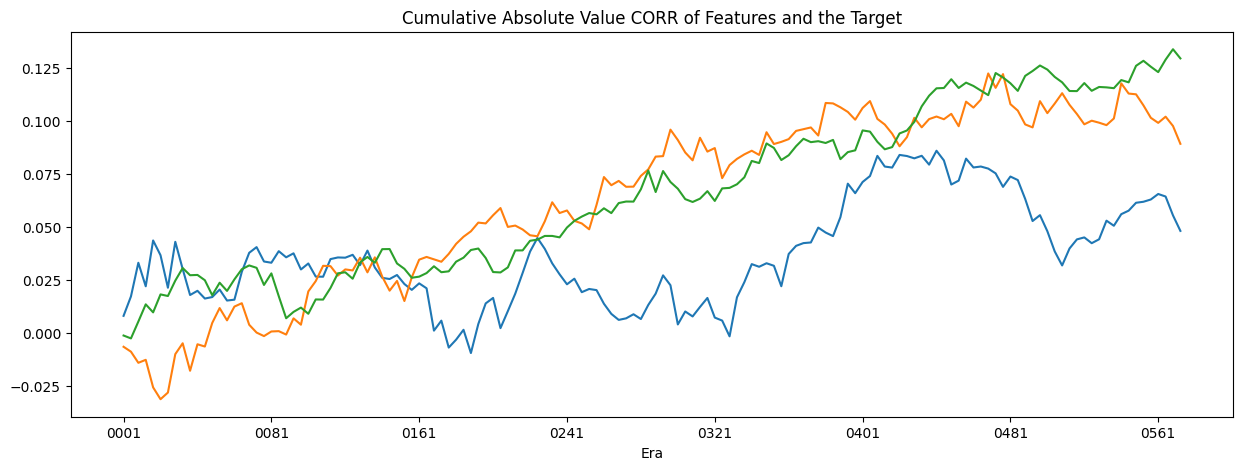

In [6]:
# import numerai_corr, you can read the source code here:
# https://github.com/numerai/numerai-tools/blob/master/numerai_tools/scoring.py
from numerai_tools.scoring import numerai_corr
import numpy as np

# Compute the per-era correlation of each serenity feature to the target
per_era_corr = train.groupby("era").apply(
    lambda d: numerai_corr(d[sm_serenity_feats], d["target"])
)

# Flip sign for negative mean correlation since we only care about magnitude
per_era_corr *= np.sign(per_era_corr.mean())

# Plot the per-era correlations
per_era_corr.cumsum().plot(
    title="Cumulative Absolute Value CORR of Features and the Target",
    figsize=(15, 5),
    legend=False,
    xlabel="Era"
  )

Let's compute some summary performance metrics as we did in the previous notebook for our model predictions.

Notice above that some features can perform extremely differently at different times over the validation period. To measure how much the performance of the feature changes over this period, we introduce a new metric:

- `delta` is the absolute difference in `mean` correlation between the first and second half of the analysis period.

In [7]:
def metrics(corr):
    corr_mean = corr.mean()
    corr_std = corr.std(ddof=0)
    corr_sharpe = corr_mean / corr_std
    max_drawdown = -(corr.cumsum().expanding(min_periods=1).max() - corr.cumsum()).max()

    eras = train.era.unique()
    halfway_era = len(eras)//2
    corr_mean_first_half = corr.loc[eras[:halfway_era]].mean()
    corr_mean_second_half = corr.loc[eras[halfway_era:]].mean()
    delta = abs(corr_mean_first_half - corr_mean_second_half)

    return {
      "mean": corr_mean,
      "std": corr_std,
      "sharpe": corr_sharpe,
      "max_drawdown": max_drawdown,
      "delta": delta
    }

# compute performance metrics for each feature
feature_metrics = [
    metrics(per_era_corr[feature_name])
    for feature_name in sm_serenity_feats
]

# convert to numeric DataFrame and sort
feature_metrics = (
    pd.DataFrame(feature_metrics, index=sm_serenity_feats)
    .apply(pd.to_numeric)
    .sort_values("mean", ascending=False)
)

feature_metrics

,mean,std,sharpe,max_drawdown,delta
feature_glandered_unimproved_peafowl,0.000899,0.004457,0.201743,-0.024903,0.000329
feature_elusive_vapoury_accomplice,0.000619,0.006414,0.096574,-0.033173,0.000904
feature_unsystematized_subcardinal_malaysia,0.000334,0.007446,0.044894,-0.054091,0.000301


Looking at the summary visualizations below, the most obvious observation is that `mean` and `sharpe` seem strongly correlated. This should not be suprising given that `sharpe` is just `mean` divided by `std`.

A more interesting obvservation is that `mean` does not seem to be strongly correlated with `std`, `max_drawdown`, or `delta`. This tells us very clearly that just because a feature has high `mean` does not mean that it is consistent or low risk.

In the next section we more closely examine `std`, `max_drawdown`, and `delta` to better understand feature risk.

array([[<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'std'}>,
        <Axes: title={'center': 'sharpe'}>],
       [<Axes: title={'center': 'max_drawdown'}>,
        <Axes: title={'center': 'delta'}>, <Axes: >]], dtype=object)

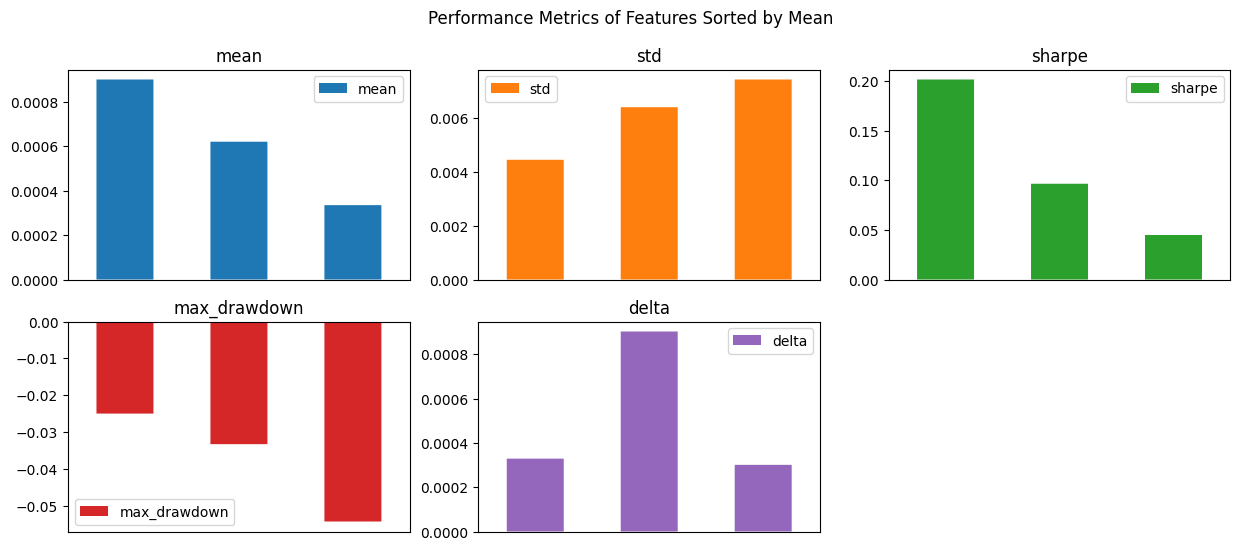

In [8]:
# plot the performance metrics of the features as bar charts sorted by mean
feature_metrics.sort_values("mean", ascending=False).plot.bar(
    title="Performance Metrics of Features Sorted by Mean",
    subplots=True,
    figsize=(15, 6),
    layout=(2, 3),
    sharex=False,
    xticks=[],
    snap=False
)

### Comparing feature risk

Below is a performance comparison of the highest and lowest `std` features. Which one looks more risky to you and why?

One might argue that the orange line looks more risky given its more sudden and violent reversals. Extrapolating forward, we may expect this volatility to continue out of sample.

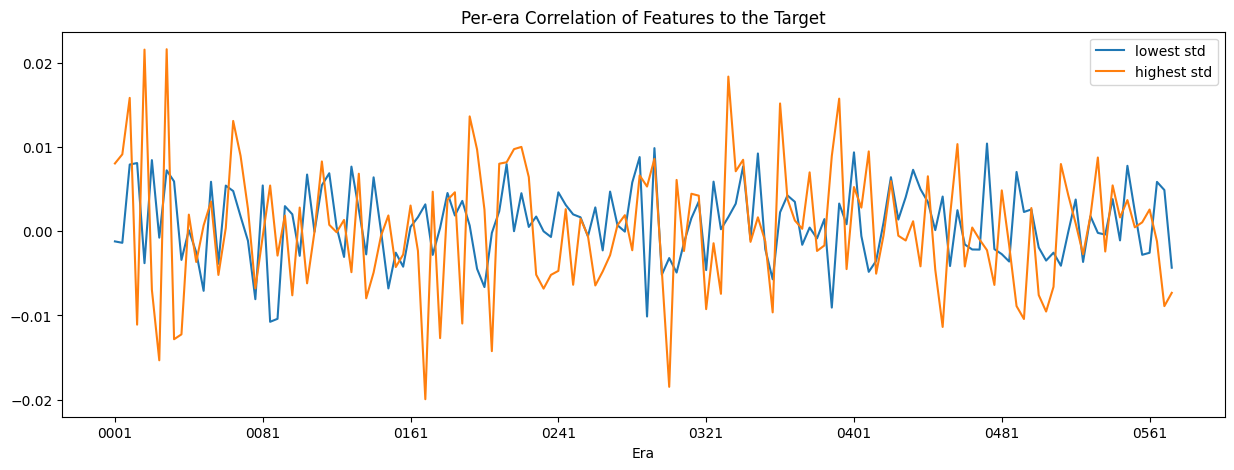

In [9]:
import matplotlib.pyplot as plt

# plot the per era correlation of the feature with the highest vs lowest std
per_era_corr[[feature_metrics["std"].idxmin(), feature_metrics["std"].idxmax()]].plot(
    figsize=(15, 5), title="Per-era Correlation of Features to the Target", xlabel="Era"
)
plt.legend(["lowest std", "highest std"])

Below is a comparison of the highest and lowest `delta` features. Which one looks more risky to you and why?

One might argue that the orange line looks more risky given the complete reversal in performance between the first and second half, despite both ending up in a similar spot. Extraoploating forward, we may expect this feature to stop working completely out-of-sample.

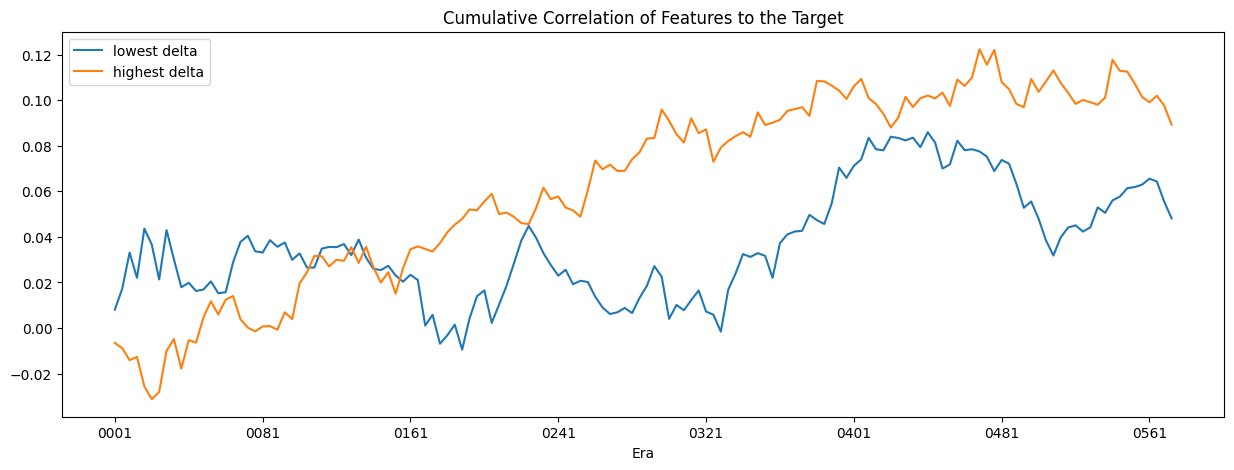

In [10]:
# plot the cumulative per era correlation of the feature with the highest vs lowest delta
per_era_corr[[feature_metrics["delta"].idxmin(), feature_metrics["delta"].idxmax()]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Era"
)
plt.legend(["lowest delta", "highest delta"])

Below is a comparison of the highest and lowest `max_drawdown` features. Which one looks more risky to you and why?

One might argue that the orange line is more risky given the huge drawdown in the middle, despite both ending up in a similar spot. Extrapolating forward, we may expect it to have another big drawdown out of sample.

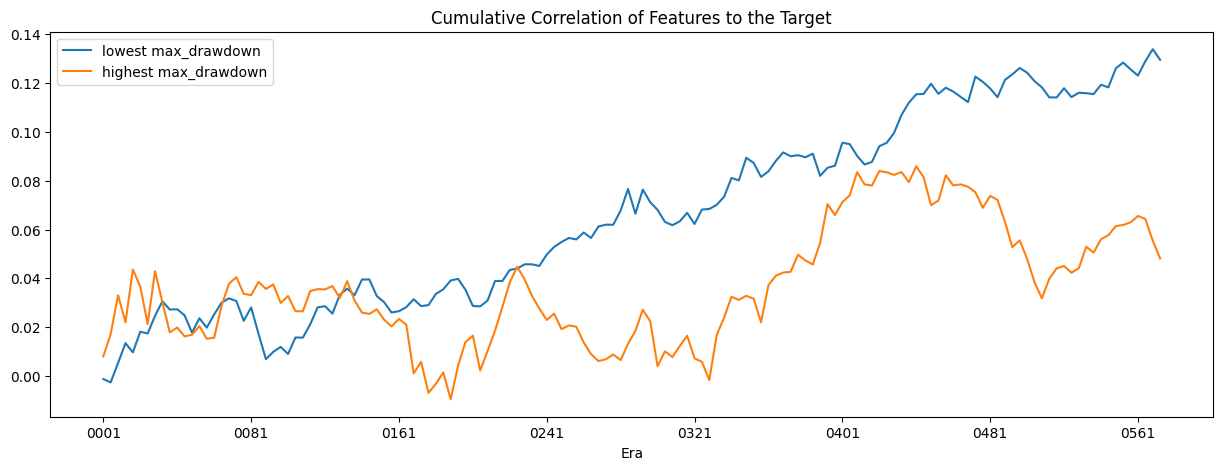

In [11]:
# plot the cumulative per era correlation of the feature with the highest vs lowest max_drawdown
per_era_corr[[feature_metrics["max_drawdown"].idxmax(), feature_metrics["max_drawdown"].idxmin()]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Era"
)
plt.legend(["lowest max_drawdown", "highest max_drawdown"])

The metrics analyzed above are only a few of many different ways you can quantify feature risk.

What are some other ways you can think of?

Think about this while we train a model on the entire small feature set.

In [12]:
import lightgbm as lgb

model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=2**4-1,
    colsample_bytree=0.1
)
# We've found the following "deep" parameters perform much better, but they require much more CPU and RAM
# model = lgb.LGBMRegressor(
#     n_estimators=30_000,
#     learning_rate=0.001,
#     max_depth=10,
#     num_leaves=2**10,
#     colsample_bytree=0.1
#     min_data_in_leaf=10000,
# )
model.fit(
    train[small_features],
    train["target"]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 688184, number of used features: 42
[LightGBM] [Info] Start training from score 0.500008


,boosting_type,'gbdt'
,num_leaves,15
,max_depth,5
,learning_rate,0.01
,n_estimators,2000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## 2. Feature Exposure

`Feature exposure` is a measure of a model's exposure to the risk of individual features, given by the Pearson correlation between a model's predictions and each feature. Let's load up and predict on the validation data for our small feature set.

In [13]:
# Download validation data
napi.download_dataset(f"{DATA_VERSION}/validation.parquet")

# Load the validation data, filtering for data_type == "validation"
validation = pd.read_parquet(
    f"{DATA_VERSION}/validation.parquet",
    columns=["era", "data_type", "target"] + small_features
)
validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]

# Downsample every 4th era to reduce memory usage and speedup validation (suggested for Colab free tier)
# Comment out the line below to use all the data
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

# Embargo overlapping eras from training data
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

# Generate predictions against the small feature set of the validation data
validation["prediction"] = model.predict(validation[small_features])

v5.0/validation.parquet: 3.49GB [00:51, 67.6MB/s]                            


### Visualizing feature exposures

As seen in the chart below, our model seems to be consistently correlated to a few features. If these features suddenly reverse or stop working, then our model predictions will likely exhibit the same risky characteristics we saw above.


/tmp/ipython-input-4193694832.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_exposures = validation.groupby("era").apply(


Text(0.5, 0.98, 'Feature Exposures')

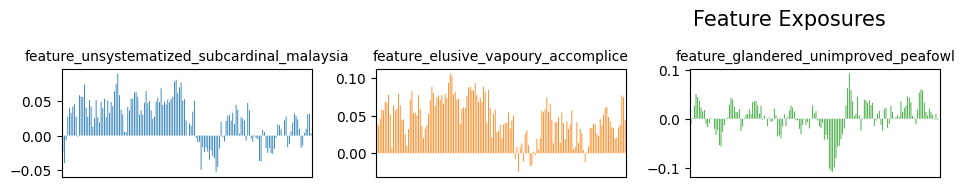

In [14]:
# Compute the Peason correlation of the predictions with each of the
# serenity features of the small feature set
feature_exposures = validation.groupby("era").apply(
    lambda d: d[sm_serenity_feats].corrwith(d["prediction"])
)

# Plot the feature exposures as bar charts
feature_exposures.plot.bar(
    title="Feature Exposures",
    figsize=(16, 10),
    layout=(7,5),
    xticks=[],
    subplots=True,
    sharex=False,
    legend=False,
    snap=False
)
for ax in plt.gcf().axes:
    ax.set_xlabel("")
    ax.title.set_fontsize(10)
plt.tight_layout(pad=1.5)
plt.gcf().suptitle("Feature Exposures", fontsize=15)

### Max feature exposure

When reviewing the visualizations above, the scale and consistency of exposure changes feature-to-feature.

Can you think of a better way to visualize this?

A more useful way to visualize the overall feature exposure of our model might be to look at the maximum feature exposure each era. This is a simple way for us to estimate the maximum exposure the model has to any one feature at any given time.

Note that we are only measuring the feature exposures of the subset of features we chose to analyze.

Mean of max feature exposure 0.050568245900825814


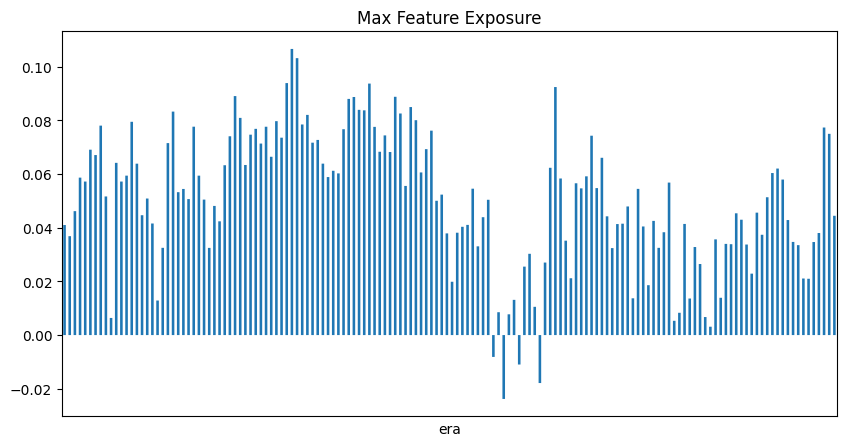

In [15]:
# Plot the max feature exposure per era
max_feature_exposure = feature_exposures.max(axis=1)
max_feature_exposure.plot(
  title="Max Feature Exposure",
  kind="bar",
  figsize=(10, 5),
  xticks=[],
  snap=False
)
# Mean max feature exposure across eras
print("Mean of max feature exposure", max_feature_exposure.mean())

## 3. Feature Neutralization

Clearly the model has some consistent exposure to the features on which it was trained.

`Feature Neutralization` is a way to reduce these feature exposures.

At a high level, neutralizing to a feature means removing the component of your predictions (or "signal") that is correlated with that feature, leaving only the residual unique component of the signal.

Read these forum posts if you want to learn more about the math behind the feature neutralization:
- https://forum.numer.ai/t/model-diagnostics-feature-exposure/899
- https://forum.numer.ai/t/an-introduction-to-feature-neutralization-exposure/4955

### Applying feature neutralization

Let's apply feature neutralization to our predictions at different porportions and see how that impacts max feature exposure.

In [16]:
# import neutralization from numerai-tools
from numerai_tools.scoring import neutralize

# Neutralize predictions per-era against features at different proportions
proportions = [0.25, 0.5, 0.75, 1.0]
for proportion in proportions:
    neutralized = validation.groupby("era", group_keys=True).apply(
        lambda d: neutralize(
          d[["prediction"]],
          d[sm_serenity_feats],
          proportion=proportion
        )
    ).reset_index().set_index("id")
    validation[f"neutralized_{proportion*100:.0f}"] = neutralized["prediction"]

# Align the neutralized predictions with the validation data
prediction_cols = ["prediction"] + [f for f in validation.columns if "neutralized" in f]
validation[["era", "target"] + prediction_cols]

/tmp/ipython-input-2805403057.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  neutralized = validation.groupby("era", group_keys=True).apply(
/tmp/ipython-input-2805403057.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  neutralized = validation.groupby("era", group_keys=True).apply(
/tmp/ipython-input-2805403057.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is dep

,era,target,prediction,neutralized_25,neutralized_50,neutralized_75,neutralized_100
id,,,,,,,
n000c290e4364875,0579,0.50,0.495167,0.370184,0.245201,0.120218,-0.004765
n002a15bc5575bbb,0579,0.25,0.516067,0.390981,0.265896,0.140810,0.015725
n00309caaa0f955e,0579,0.75,0.513778,0.388530,0.263283,0.138035,0.012787
n0039cbdcf835708,0579,0.50,0.507834,0.382948,0.258063,0.133178,0.008293
n004143458984f89,0579,0.50,0.484917,0.360013,0.235109,0.110204,-0.014700
...,...,...,...,...,...,...,...
nffaa77add7e2a53,1175,0.25,0.498365,0.373257,0.248148,0.123040,-0.002069
nffd21984a44c53f,1175,0.50,0.500667,0.375778,0.250889,0.126000,0.001111
nffd33ef0b6cd58e,1175,0.50,0.502454,0.377493,0.252531,0.127570,0.002609


We can see below that, as neutralization proportion reaches 1, feature exposure reaches 0.

/tmp/ipython-input-2249315608.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validation.groupby("era").apply(
/tmp/ipython-input-2249315608.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validation.groupby("era").apply(
/tmp/ipython-input-2249315608.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping column

mean feature exposures:
prediction         0.057
neutralized_25     0.042
neutralized_50     0.028
neutralized_75     0.014
neutralized_100    0.000
dtype: float64


<Axes: title={'center': 'Max Feature Exposures'}, xlabel='era'>

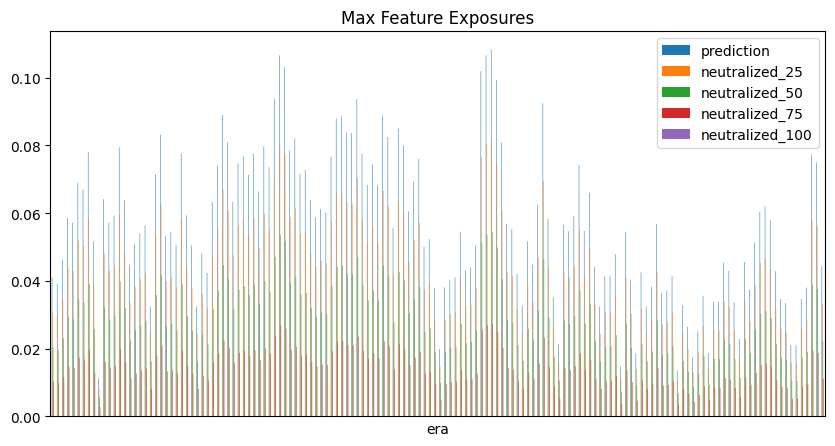

In [18]:
# Compute max feature exposure for each set of predictions
max_feature_exposures = pd.concat([
    validation.groupby("era").apply(
        lambda d: d[sm_serenity_feats].corrwith(d[col]).abs().max()
    ).rename(col)
    for col in prediction_cols
], axis=1)

# print mean feature exposure of each proportion
print('mean feature exposures:')
print(round(max_feature_exposures.mean(), 3))

# Plot max feature exposures
max_feature_exposures.plot.bar(
  title="Max Feature Exposures",
  figsize=(10, 5),
  xticks=[],
  snap=False
)


### Performance impact of neutralization

Looking at the performance below, we see that there is a marginal performance improvement as we increase the porportion of neutralization applied, but the overall shape of the line remains largely the same.

You might see below that sometimes the optimal neutralization proportion is not 1.0 over the validation period - seeming to imply that a small amount of feature exposure can sometimes be helpful. After completing this tutorial, continue experimenting with neutralizing at different proportions and analyze the tradeoff between reducing exposure and improving performance.

/tmp/ipython-input-1183669635.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = validation.groupby("era").apply(


<Axes: title={'center': 'Cumulative Correlation of Neutralized Predictions'}, xlabel='era'>

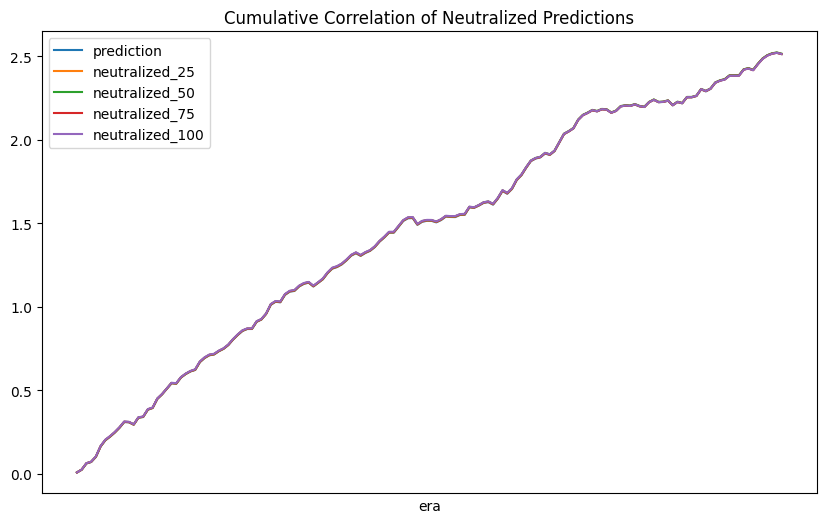

In [21]:
# calculate per-era CORR for each set of predictions
correlations = validation.groupby("era").apply(
    lambda d: numerai_corr(d[prediction_cols], d["target"])
)

# calculate the cumulative corr across eras for each neutralization proportion
cumulative_correlations = correlations.cumsum().sort_index()

# Show the cumulative correlations
pd.DataFrame(cumulative_correlations).plot(
    title="Cumulative Correlation of Neutralized Predictions",
    figsize=(10, 6),
    xticks=[]
)

Let's look at some other aggregate metrics like `mean`, `std`, `sharpe`, and `max_drawdown`.

What kind of relationship do you see between neutralization proportion and overall performance?

In [22]:
summary_metrics = {}
for col in prediction_cols:
    mean = correlations[col].mean()
    std = correlations[col].std(ddof=0)
    sharpe = mean / std
    rolling_max = cumulative_correlations[col].expanding(min_periods=1).max()
    max_drawdown = (rolling_max - cumulative_correlations[col]).max()
    summary_metrics[col] = {
        "mean": mean,
        "std": std,
        "sharpe": sharpe,
        "max_drawdown": max_drawdown,
    }
pd.set_option('display.float_format', lambda x: '%f' % x)
pd.DataFrame(summary_metrics).T

,mean,std,sharpe,max_drawdown
prediction,0.016763,0.018580,0.902247,0.040911
neutralized_25,0.016767,0.018595,0.901695,0.041098
neutralized_50,0.016780,0.018584,0.902933,0.041238
neutralized_75,0.016765,0.018567,0.902950,0.041385
neutralized_100,0.016767,0.018550,0.903882,0.041532


### Neutralizing different groups
Given that we trained our model on the entire `small` set of features, it is not surprising that neutralizing just a small subset of 34 features will have a small impact on performance. So let's re-run this experiment but this time try to neutralize the each group within `small` while holding porportion constant at 100%.

As we can see in the performance chart below, neutralizing against the different groups gives a much more pronounced impact on performance, which makes sense since these groups are fundamentally different from one another.

/tmp/ipython-input-2089295116.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  neutralized = validation.groupby("era", group_keys=True).apply(
/tmp/ipython-input-2089295116.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  neutralized = validation.groupby("era", group_keys=True).apply(
/tmp/ipython-input-2089295116.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is dep

<Axes: title={'center': 'Cumulative Correlation of Neutralized Predictions'}, xlabel='era'>

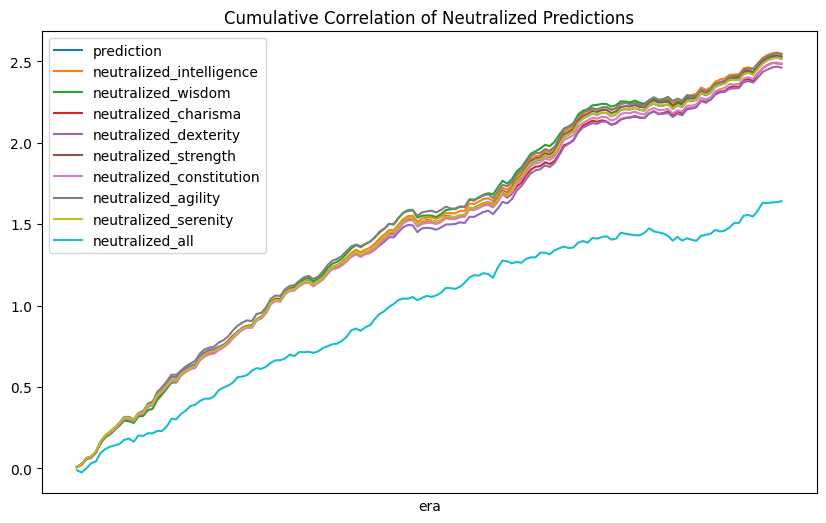

In [24]:
# neutralize preds against each group
for group in groups:
    neutral_feature_subset = list(subgroups["small"][group])
    neutralized = validation.groupby("era", group_keys=True).apply(
        lambda d: neutralize(d[["prediction"]], d[neutral_feature_subset])
    ).reset_index().set_index("id")
    validation[f"neutralized_{group}"] = neutralized["prediction"]

group_neutral_cols = ["prediction"] + [f"neutralized_{group}" for group in groups]
group_neutral_corr = validation.groupby("era").apply(
    lambda d: numerai_corr(d[group_neutral_cols], d["target"])
)
group_neutral_cumsum = group_neutral_corr.cumsum()

group_neutral_cumsum.plot(
  title="Cumulative Correlation of Neutralized Predictions",
  figsize=(10, 6),
  xticks=[]
)

We see that neutralizing against some groups help with CORR while others seem to hurt. Can you think of why this might be the case?

Let's see if this same characteristic applies to MMC:

v4.3/meta_model.parquet: 29.0MB [00:00, 35.1MB/s]                            
/tmp/ipython-input-13882294.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_era_mmc = validation.dropna().groupby("era").apply(


<Axes: title={'center': 'Cumulative MMC of Neutralized Predictions'}, xlabel='era'>

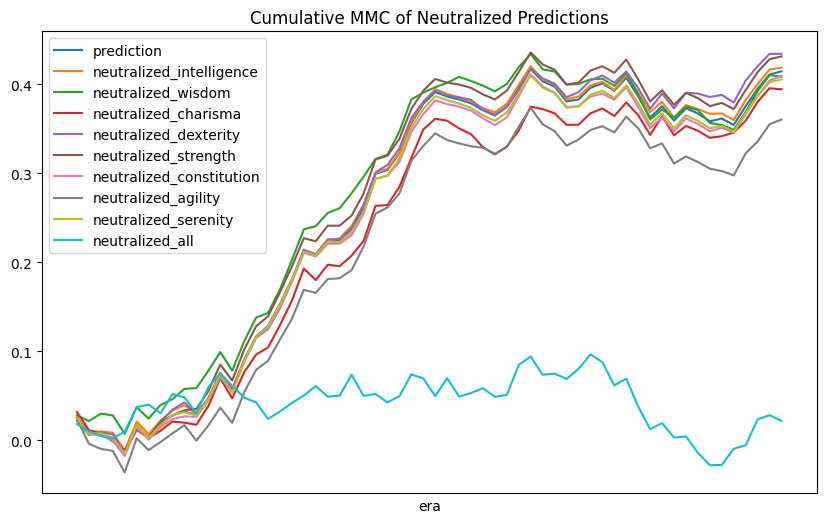

In [25]:
from numerai_tools.scoring import correlation_contribution

# Download and join in the meta_model for the validation eras
napi.download_dataset(f"v4.3/meta_model.parquet", round_num=842)
validation["meta_model"] = pd.read_parquet(
    f"v4.3/meta_model.parquet"
)["numerai_meta_model"]

# Compute the per-era mmc between our predictions, the meta model, and the target values
per_era_mmc = validation.dropna().groupby("era").apply(
    lambda x: correlation_contribution(
        x[group_neutral_cols], x["meta_model"], x["target"]
    )
)

cumsum_mmc = per_era_mmc.cumsum()

cumsum_mmc.plot(
  title="Cumulative MMC of Neutralized Predictions",
  figsize=(10, 6),
  xticks=[]
)

Perhaps the most interesting observation is that neutralizing against `all` of the groups within `small` performs by far the worst in terms of `mean` and `sharpe` of CORR or MMC. Can you think of why this might be the case?

In [27]:
group_neutral_summary_metrics = {}
for col in group_neutral_cols:
    corr_mean = group_neutral_corr[col].mean()
    corr_std = group_neutral_corr[col].std()
    corr_sharpe = corr_mean / corr_std
    corr_rolling_max = group_neutral_cumsum[col].expanding(min_periods=1).max()
    corr_max_drawdown = (corr_rolling_max - group_neutral_cumsum[col]).max()
    mmc_mean = per_era_mmc[col].mean()
    mmc_std = per_era_mmc[col].std()
    mmc_sharpe = mmc_mean / mmc_std
    mmc_rolling_max = cumsum_mmc[col].expanding(min_periods=1).max()
    mmc_max_drawdown = (rolling_max - cumsum_mmc[col]).max()
    group_neutral_summary_metrics[col] = {
        "corr_mean": corr_mean,
        "mmc_mean": mmc_mean,
        "corr_std": corr_std,
        "mmc_std": mmc_std,
        "corr_sharpe": corr_sharpe,
        "mmc_sharpe": mmc_sharpe,
        "corr_max_drawdown": corr_max_drawdown,
        "mmc_max_drawdown": mmc_max_drawdown,
    }
pd.set_option('display.float_format', lambda x: '%f' % x)
pd.DataFrame(group_neutral_summary_metrics).T

,corr_mean,mmc_mean,corr_std,mmc_std,corr_sharpe,mmc_sharpe,corr_max_drawdown,mmc_max_drawdown
prediction,0.016763,0.006914,0.018642,0.016378,0.899234,0.422153,0.040911,1.949824
neutralized_intelligence,0.016973,0.006981,0.018595,0.016106,0.912806,0.433412,0.038507,1.944338
neutralized_wisdom,0.016867,0.006811,0.018325,0.015608,0.920476,0.436368,0.045409,1.955404
neutralized_charisma,0.016555,0.006577,0.018446,0.016334,0.897497,0.402639,0.034907,1.967068
neutralized_dexterity,0.016407,0.007240,0.018576,0.015867,0.883227,0.456288,0.043867,1.927256
neutralized_strength,0.016844,0.007191,0.018629,0.016378,0.904150,0.439084,0.040946,1.932065
neutralized_constitution,0.016566,0.006826,0.018467,0.016325,0.897059,0.418166,0.040313,1.958392
neutralized_agility,0.016960,0.006010,0.018560,0.016761,0.913808,0.358560,0.037780,2.007267
neutralized_serenity,0.016767,0.006763,0.018612,0.016328,0.900864,0.414211,0.041532,1.957557
neutralized_all,0.010936,0.000367,0.016971,0.015585,0.644399,0.023564,0.076985,2.339628


**Based** on our simple analysis above, it seems like neutralizing `serenity` group within `small` at porportion of 1 may be the best choice for performance. What do you think?

In your research, you may want to experiment with neutralizing different subsets of features at different porportions and make your own judgement on how to balance the risk reward benefits of neutralization. You may even consider incorporating neutralization into the objective function of your training instead of applying it to predictions like we do here.

Lastly, whether you want to apply feature neutralization to your model or not is completely up to you. In fact, many great performing models have no feature neutralization at all!   



## 4. Building a feature-neutral model

To wrap up this notebook, let's build and upload our new feature neutral model.

In [28]:

from numerai_tools.scoring import neutralize
def predict_neutral(live_features: pd.DataFrame, _live_benchmark_models: pd.DataFrame = None) -> pd.DataFrame:
    # make predictions using all features
    predictions = pd.DataFrame(
        model.predict(live_features[small_features]),
        index=live_features.index,
        columns=["prediction"]
    )
    # neutralize predictions to a subset of features
    neutralized = neutralize(predictions, live_features[sm_serenity_feats])
    return neutralized.rank(pct=True)

In [31]:
# Quick test
napi.download_dataset(f"{DATA_VERSION}/live.parquet")
live_features = pd.read_parquet(f"{DATA_VERSION}/live.parquet", columns=small_features)
predict_neutral(live_features)

,prediction
id,
n00155fa0f4500f3,0.038662
n001b0c8a35aa85e,0.870929
n001c1ab9e5f46f9,0.075985
n0020ee658d03770,0.047584
n002c04ad811f2fb,0.035688
...,...
nffb77f046810f95,0.413234
nffba832ad9aed90,0.385874
nffdb1f7bfff90f7,0.653383


In [33]:
# Use the cloudpickle library to serialize your function and its dependencies
import cloudpickle
p = cloudpickle.dumps(predict_neutral)
with open("feature_neutralization.pkl", "wb") as f:
    f.write(p)

In [34]:
# Download file if running in Google Colab
try:
    from google.colab import files
    files.download('feature_neutralization.pkl')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

That's it! Now head back to [numer.ai](numer.ai) to upload your model!